In [1]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Метрики и функции

In [2]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / (ss_tot + 1e-12)

def sigmoid(z):
    z = np.clip(z, -40, 40)
    return 1.0 / (1.0 + np.exp(-z))

def log_loss_binary(y_true, y_proba): ##ф-я потерь
    return -np.mean(y_true * np.log(y_proba) + (1 - y_true) * np.log(1 - y_proba))

def accuracy(y_true, y_pred_labels):
    return np.mean(y_true == y_pred_labels)

def precision_recall_f1(y_true, y_pred_labels):
    tp = np.sum((y_true == 1) & (y_pred_labels == 1))
    fp = np.sum((y_true == 0) & (y_pred_labels == 1))
    fn = np.sum((y_true == 1) & (y_pred_labels == 0))
    precision = tp / (tp + fp + 1e-12) ## частота предск единиц
    recall    = tp / (tp + fn + 1e-12) ## полнота
    f1        = 2 * precision * recall / (precision + recall + 1e-12) ##среднее
    return precision, recall, f1


Сплит и стандартизатор

In [3]:
def train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42):
    n = X.shape[0]; idx = np.arange(n)
    if shuffle:
        rng = np.random.default_rng(seed=random_state); rng.shuffle(idx)
    test_n = int(n * test_size)

    test_idx = idx[:test_n]; train_idx = idx[test_n:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

class StandardScaler: ## для стабильного и быстрого град спуска
    def __init__(self): self.mean_, self.std_ = None, None
    def fit(self, X):
        self.mean_ = X.mean(axis=0); self.std_ = X.std(axis=0)
        self.std_[self.std_ == 0] = 1.0
        return self
    def transform(self, X): return (X - self.mean_) / self.std_
    def fit_transform(self, X): return self.fit(X).transform(X)


Линейная и логистическая модели


In [4]:
class LinearRegression:
    def __init__(self, lr=0.05, n_epochs=1000, verbose=False):
        self.lr, self.n_epochs, self.verbose = lr, n_epochs, verbose
        self.w, self.b = None, 0.0
        self.loss_history_, self.r2_history_ = [], []

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        n, d = X_train.shape
        limit = 1 / math.sqrt(d)
        rng = np.random.default_rng(42)
        self.w = rng.uniform(-limit, limit, size=(d,))
        self.b = 0.0

        for epoch in range(self.n_epochs):
            y_pred = self.predict(X_train)
            loss = mse(y_train, y_pred)
            grad_w = (-2.0 / n) * (X_train.T @ (y_train - y_pred))
            grad_b = (-2.0 / n) * np.sum(y_train - y_pred)

            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

            self.loss_history_.append(loss)
            r2 = r2_score(y_val, self.predict(X_val)) if X_val is not None else r2_score(y_train, y_pred)
            self.r2_history_.append(r2)

            if self.verbose and epoch % 100 == 0:
                print(f"[Linear] epoch={epoch:4d}  loss={loss:.6f}  R2={r2:.4f}")
        return self

    def predict(self, X):
        return X @ self.w + self.b


class LogisticRegression:
    def __init__(self, lr=0.05, n_epochs=1000, verbose=False):
        self.lr, self.n_epochs, self.verbose = lr, n_epochs, verbose
        self.w, self.b = None, 0.0
        self.loss_history_, self.acc_history_, self.f1_history_ = [], [], []

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        n, d = X_train.shape
        limit = 1 / math.sqrt(d)
        rng = np.random.default_rng(42)
        self.w = rng.uniform(-limit, limit, size=(d,))
        self.b = 0.0

        y_train = y_train.reshape(-1)
        for epoch in range(self.n_epochs):
            z = X_train @ self.w + self.b
            p = sigmoid(z)

            loss = log_loss_binary(y_train, p)
            grad = p - y_train
            grad_w = (X_train.T @ grad) / n
            grad_b = np.sum(grad) / n

            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

            self.loss_history_.append(loss)
            if X_val is not None:
                y_pred = self.predict(X_val)
                acc = accuracy(y_val, y_pred)
                _, _, f1 = precision_recall_f1(y_val, y_pred)
            else:
                y_pred = (p >= 0.5).astype(int)
                acc = accuracy(y_train, y_pred)
                _, _, f1 = precision_recall_f1(y_train, y_pred)

            self.acc_history_.append(acc)
            self.f1_history_.append(f1)

            if self.verbose and epoch % 100 == 0:
                print(f"[Logistic] epoch={epoch:4d}  loss={loss:.6f}  acc={acc:.4f}  f1={f1:.4f}")
        return self

    def predict(self, X, thr=0.5):
        p = sigmoid(X @ self.w + self.b)
        return (p >= thr).astype(int)


Загрузка датасетов

In [5]:
def _norm(s: str) -> str:
    return s.strip().lower().replace(" ", "_")

def load_california(path="data/California_Houses.csv", target_col="Median_House_Value"):
    df = pd.read_csv(path)
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(df[col].median())
    obj_cols = df.select_dtypes(include=["object","category"]).columns.tolist()
    if obj_cols:
        df = pd.get_dummies(df, columns=obj_cols, drop_first=True)

    y = df[target_col].values.astype(np.float64)
    X = df.drop(columns=[target_col]).values.astype(np.float64)

    return X, y, df.drop(columns=[target_col]).columns.tolist()

def load_titanic(path=("data/Titanic-Dataset.csv"), target_col="Survived"):
    df = pd.read_csv(path)
    cols_pref = [c for c in ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"] if c in df.columns]
    if not cols_pref: cols_pref = [c for c in df.columns if c != target_col]
    use_df = df[cols_pref].copy()
    if "Sex" in use_df.columns: use_df["Sex"] = use_df["Sex"].map({"male":0,"female":1}).astype(float)
    for col in use_df.select_dtypes(include=[np.number]).columns:
        use_df[col] = use_df[col].fillna(use_df[col].median())
    obj_cols = use_df.select_dtypes(include=["object","category"]).columns.tolist()
    if obj_cols: use_df = pd.get_dummies(use_df, columns=obj_cols, drop_first=True)
    y = df[target_col].values.astype(int)
    X = use_df.values.astype(np.float64)
    return X, y, use_df.columns.tolist(), path


Загрузка данных, препроцессинг, обучение для линейной регрессии


In [6]:
print("California Houses")
Xc, y_raw, feats_c = load_california("data/California_Houses.csv", target_col="Median_House_Value")

x_scaler = StandardScaler()
Xc = x_scaler.fit_transform(Xc)

y_scaler = StandardScaler()
y = y_scaler.fit_transform(y_raw.reshape(-1, 1)).reshape(-1)

Xc_tr, Xc_te, y_tr, y_te = train_test_split(Xc, y, test_size=0.2, shuffle=True, random_state=42)

lin = LinearRegression(lr=0.05, n_epochs=1500, verbose=True)
lin.fit(Xc_tr, y_tr, X_val=Xc_te, y_val=y_te)

y_pred_te = lin.predict(Xc_te)

print(f"Test MSE: {mse(y_te, y_pred_te):.4f}")
print(f"Test R2: {r2_score(y_te, y_pred_te):.4f}")


California Houses
[Linear] epoch=   0  loss=0.986646  R2=0.2845
[Linear] epoch= 100  loss=0.366450  R2=0.6172
[Linear] epoch= 200  loss=0.361356  R2=0.6199
[Linear] epoch= 300  loss=0.359007  R2=0.6217
[Linear] epoch= 400  loss=0.357588  R2=0.6233
[Linear] epoch= 500  loss=0.356619  R2=0.6245
[Linear] epoch= 600  loss=0.355916  R2=0.6255
[Linear] epoch= 700  loss=0.355389  R2=0.6263
[Linear] epoch= 800  loss=0.354986  R2=0.6270
[Linear] epoch= 900  loss=0.354672  R2=0.6275
[Linear] epoch=1000  loss=0.354423  R2=0.6279
[Linear] epoch=1100  loss=0.354222  R2=0.6283
[Linear] epoch=1200  loss=0.354056  R2=0.6286
[Linear] epoch=1300  loss=0.353917  R2=0.6288
[Linear] epoch=1400  loss=0.353797  R2=0.6291
Test MSE: 0.3615
Test R2: 0.6292


Графики для линейной регрессии

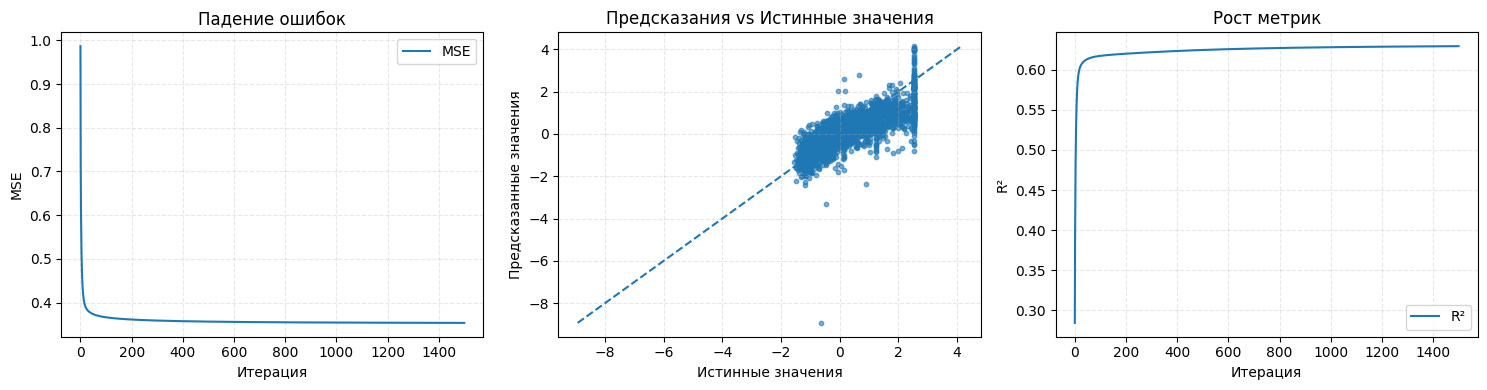

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(lin.loss_history_, label="MSE")
axs[0].set_title("Падение ошибок")
axs[0].set_xlabel("Итерация"); axs[0].set_ylabel("MSE")
axs[0].legend(); axs[0].grid(True, linestyle="--", alpha=0.3)

axs[1].scatter(y_te, y_pred_te, s=10, alpha=0.6)
mn = float(min(np.min(y_te), np.min(y_pred_te)))
mx = float(max(np.max(y_te), np.max(y_pred_te)))
axs[1].plot([mn, mx], [mn, mx], linestyle="--", linewidth=1.5)
axs[1].set_title("Предсказания vs Истинные значения")
axs[1].set_xlabel("Истинные значения"); axs[1].set_ylabel("Предсказанные значения")
axs[1].grid(True, linestyle="--", alpha=0.3)

axs[2].plot(lin.r2_history_, label="R²")
axs[2].set_title("Рост метрик")
axs[2].set_xlabel("Итерация"); axs[2].set_ylabel("R²")
axs[2].legend(); axs[2].grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


Загрузка, препроцессинг, обучение, метрики для логистической регрессии

In [8]:
print("Titanic")
Xt, yt, feats_t, used_path = load_titanic()

scaler_t = StandardScaler()
Xt = scaler_t.fit_transform(Xt)
Xt_tr, Xt_te, yt_tr, yt_te = train_test_split(Xt, yt, test_size=0.2, shuffle=True, random_state=42)

log = LogisticRegression(lr=0.1, n_epochs=1200, verbose=True)
log.fit(Xt_tr, yt_tr, X_val=Xt_te, y_val=yt_te)

z = Xt_te @ log.w + log.b
proba_te = sigmoid(z)
yt_pred  = (proba_te >= 0.5).astype(int)

ll  = log_loss_binary(yt_te, proba_te)
acc = accuracy(yt_te, yt_pred)
prec, rec, f1 = precision_recall_f1(yt_te, yt_pred)

print(f"Test LogLoss : {ll:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")


Titanic
[Logistic] epoch=   0  loss=0.756460  acc=0.4607  f1=0.4725
[Logistic] epoch= 100  loss=0.461746  acc=0.7921  f1=0.7517
[Logistic] epoch= 200  loss=0.446965  acc=0.7978  f1=0.7600
[Logistic] epoch= 300  loss=0.443666  acc=0.8090  f1=0.7703
[Logistic] epoch= 400  loss=0.442657  acc=0.8090  f1=0.7703
[Logistic] epoch= 500  loss=0.442324  acc=0.8090  f1=0.7703
[Logistic] epoch= 600  loss=0.442211  acc=0.8090  f1=0.7703
[Logistic] epoch= 700  loss=0.442173  acc=0.8090  f1=0.7703
[Logistic] epoch= 800  loss=0.442160  acc=0.8090  f1=0.7703
[Logistic] epoch= 900  loss=0.442155  acc=0.8090  f1=0.7703
[Logistic] epoch=1000  loss=0.442154  acc=0.8090  f1=0.7703
[Logistic] epoch=1100  loss=0.442153  acc=0.8090  f1=0.7703
Test LogLoss : 0.4421
Test Accuracy: 0.8090
Precision: 0.8261  Recall: 0.7215  F1: 0.7703


Графики логистической регрессии

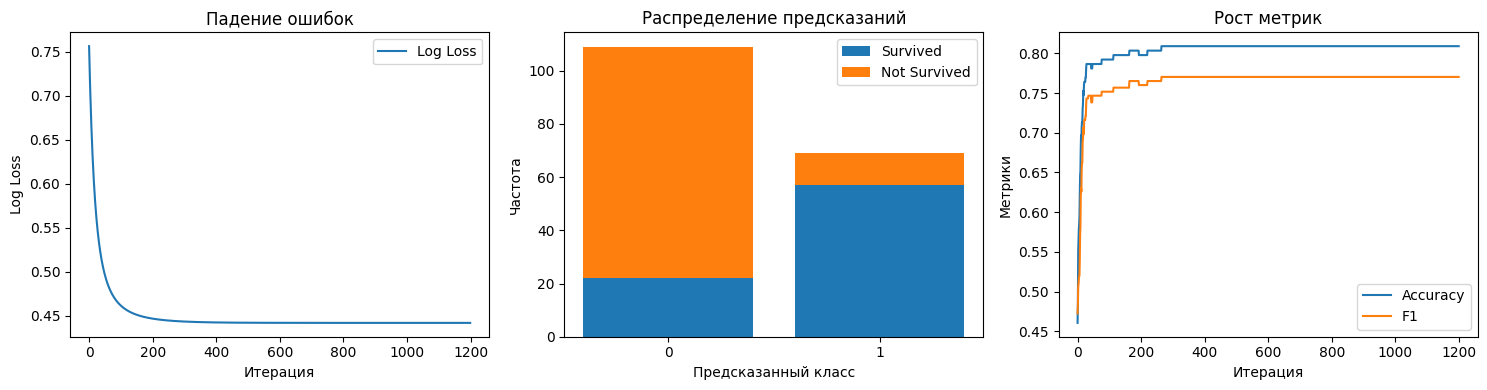

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(log.loss_history_, label="Log Loss")
axs[0].set_title("Падение ошибок")
axs[0].set_xlabel("Итерация"); axs[0].set_ylabel("Log Loss")
axs[0].legend()

pred_classes = np.array([0, 1])
cnt_true1 = np.array([np.sum((yt_pred == c) & (yt_te == 1)) for c in pred_classes])  # Survived
cnt_true0 = np.array([np.sum((yt_pred == c) & (yt_te == 0)) for c in pred_classes])  # Not Survived
axs[1].bar(pred_classes, cnt_true1, label="Survived")
axs[1].bar(pred_classes, cnt_true0, bottom=cnt_true1, label="Not Survived")
axs[1].set_title("Распределение предсказаний")
axs[1].set_xlabel("Предсказанный класс"); axs[1].set_ylabel("Частота")
axs[1].set_xticks([0, 1]); axs[1].set_xticklabels(["0", "1"])
axs[1].legend()

axs[2].plot(log.acc_history_, label="Accuracy")
axs[2].plot(log.f1_history_,  label="F1")
axs[2].set_title("Рост метрик")
axs[2].set_xlabel("Итерация"); axs[2].set_ylabel("Метрики")
axs[2].legend()

plt.tight_layout()
plt.show()
